In [ ]:
# ================================================================
# CELL 1: Install and Import Dependencies
# ================================================================

import os
import glob
import warnings
from datetime import datetime
from pathlib import Path

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import torchio as tio
from torchio import DATA, LOCATION
from torchio.transforms import RescaleIntensity, Compose, RandomFlip, RandomAffine
from torchio.data import GridSampler, GridAggregator
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

from monai.networks.nets import UNet
from monai.networks.layers import Norm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("✅ All packages imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")

✅ All packages imported successfully!
PyTorch version: 2.2.2
CUDA available: False


In [12]:
# ================================================================
# CELL 2: Configuration and Hyperparameters
# ================================================================

class Config:
    """Configuration class for easy parameter management"""
    
    # Data paths 
    data_dir = r"C:\Users\mah22\Downloads\project\PMC dataset"  
    output_dir = "./MRI_Translation_Results"
    
    # Training parameters
    batch_size = 4                   # Reduce if memory issues
    patch_size = (64, 64, 64)        # 3D patch size
    lr = 2e-4                        # Learning rate
    lambda_recon = 100               # Reconstruction loss weight
    max_epochs = 1000                # Maximum epochs
    
    # Cross-validation
    n_folds = 5                      # Number of CV folds
    fold_to_run = None               # Set to specific fold (0-4) or None for all
    
    # Data loading
    samples_per_volume = 16          # Patches per volume during training
    max_queue_length = 800           # Queue size for patch sampling
    num_workers = 4                  # Data loading workers
    
    # Model parameters
    display_step = 10                # How often to save sample images
    patience = 50                    # Early stopping patience
    
    # Technical
    seed = 42
    precision = 32                   # Mixed precision (16) or full (32)
    
    def __str__(self):
        return "\n".join([f"{k}: {v}" for k, v in self.__dict__.items()])

# Create config instance
config = Config()
print("Configuration:")
print(config)

Configuration:



In [13]:
# ================================================================
# CELL 3: Set Reproducibility
# ================================================================

def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    pl.seed_everything(seed, workers=True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"✅ Random seed set to {seed}")

set_seed(config.seed)

Seed set to 42


✅ Random seed set to 42


In [14]:
# ================================================================
# CELL 4: Discriminator Architecture
# ================================================================

class DownSampleConvDiscri(nn.Module):
    """Downsampling convolutional block for discriminator"""
    
    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1,
                 activation=True, batchnorm=True, dropout=0.0):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel,
                              stride=strides, padding=padding, bias=not batchnorm)
        self.batchnorm = batchnorm
        self.activation = activation
        self.dropout = dropout > 0
        
        if batchnorm:
            self.bn = nn.BatchNorm3d(out_channels)
        if activation:
            self.act = nn.LeakyReLU(0.2, inplace=True)
        if self.dropout:
            self.drop = nn.Dropout3d(dropout)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        if self.dropout:
            x = self.drop(x)
        return x


class PatchGAN(nn.Module):
    """3D PatchGAN Discriminator"""
    
    def __init__(self, input_channels, ndf=64):
        super().__init__()
        # C64-C128-C256-C512
        self.d1 = DownSampleConvDiscri(input_channels, ndf, batchnorm=False)
        self.d2 = DownSampleConvDiscri(ndf, ndf * 2)
        self.d3 = DownSampleConvDiscri(ndf * 2, ndf * 4)
        self.d4 = DownSampleConvDiscri(ndf * 4, ndf * 8, strides=1)
        self.final = nn.Conv3d(ndf * 8, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x, y):
        """
        x: generated/real image (3T MRI)
        y: conditioning image (1.5T MRI)
        """
        x = torch.cat([x, y], dim=1)  # Concatenate along channel dimension
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        return self.final(x)

print("✅ Discriminator architecture defined")

✅ Discriminator architecture defined


In [15]:
# ================================================================
# CELL 5: Utility Functions
# ================================================================

def _weights_init(m):
    """Initialize network weights"""
    if isinstance(m, (nn.Conv3d, nn.ConvTranspose3d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm3d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)


def save_sample_images(cond, fake, real, epoch, fold_idx, outputs_folder, figsize=(15, 5)):
    """Save sample images for monitoring"""
    
    def get_central_slice(volume):
        volume = volume.detach().cpu()
        if volume.dim() == 5:  # [B, C, D, H, W]
            volume = volume[0, 0]
        elif volume.dim() == 4:  # [C, D, H, W]
            volume = volume[0]
        
        central_idx = volume.shape[0] // 2
        return volume[central_idx].numpy()
    
    # Get central slices
    cond_slice = get_central_slice(cond)
    fake_slice = get_central_slice(fake)
    real_slice = get_central_slice(real)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    axes[0].imshow(cond_slice, cmap='gray')
    axes[0].set_title('1.5T MRI (Input)')
    axes[0].axis('off')
    
    axes[1].imshow(fake_slice, cmap='gray')
    axes[1].set_title('Generated 3T MRI')
    axes[1].axis('off')
    
    axes[2].imshow(real_slice, cmap='gray')
    axes[2].set_title('Real 3T MRI (Target)')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(outputs_folder, exist_ok=True)
    save_path = os.path.join(outputs_folder, f'fold_{fold_idx}_epoch_{epoch:03d}_samples.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()  # Display in notebook
    plt.close(fig)

print("✅ Utility functions defined")

✅ Utility functions defined


In [16]:
# ================================================================
# CELL 6: Main Model Class
# ================================================================

class MRIPix2Pix(pl.LightningModule):
    """3D Pix2Pix model for MRI 1.5T to 3T translation"""
    
    def __init__(self, in_channels=1, out_channels=1, learning_rate=2e-4, 
                 lambda_recon=100, display_step=10, patch_size=(64,64,64)):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        
        # Generator (3D UNet)
        self.generator = UNet(
            spatial_dims=3,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(32, 64, 128, 256, 512),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
            dropout=0.1,
        )
        
        # Discriminator (PatchGAN)
        self.discriminator = PatchGAN(in_channels + out_channels, ndf=64)
        
        # Initialize weights
        self.generator.apply(_weights_init)
        self.discriminator.apply(_weights_init)
        
        # Loss functions
        self.adversarial_loss = nn.BCEWithLogitsLoss()
        self.reconstruction_loss = nn.L1Loss()  # L1 better for medical images
        
        # For storing validation outputs
        self.validation_step_outputs = []

    def forward(self, x):
        """Forward pass through generator"""
        return self.generator(x)

    def prepare_batch(self, batch):
        """Extract data from TorchIO batch"""
        return batch['mri_3t'][DATA], batch['mri_15t'][DATA]

    def configure_optimizers(self):
        """Configure optimizers with learning rate scheduling"""
        gen_opt = torch.optim.Adam(
            self.generator.parameters(), 
            lr=self.hparams.learning_rate, 
            betas=(0.5, 0.999)
        )
        disc_opt = torch.optim.Adam(
            self.discriminator.parameters(), 
            lr=self.hparams.learning_rate, 
            betas=(0.5, 0.999)
        )
        
        # Learning rate schedulers
        gen_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            gen_opt, mode='min', factor=0.5, patience=10, verbose=True
        )
        disc_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            disc_opt, mode='min', factor=0.5, patience=10, verbose=True
        )
        
        return [
            {"optimizer": disc_opt, "lr_scheduler": {"scheduler": disc_scheduler, "monitor": "val/D_loss"}},
            {"optimizer": gen_opt, "lr_scheduler": {"scheduler": gen_scheduler, "monitor": "val/G_loss"}}
        ]

    def generator_step(self, real_3t, cond_15t):
        """Generator training step"""
        fake_3t = self.generator(cond_15t)
        
        # Adversarial loss
        fake_logits = self.discriminator(fake_3t, cond_15t)
        adv_loss = self.adversarial_loss(fake_logits, torch.ones_like(fake_logits))
        
        # Reconstruction loss
        recon_loss = self.reconstruction_loss(fake_3t, real_3t)
        
        # Total generator loss
        gen_loss = adv_loss + self.hparams.lambda_recon * recon_loss
        
        return gen_loss, adv_loss, recon_loss, fake_3t

    def discriminator_step(self, real_3t, cond_15t):
        """Discriminator training step"""
        # Generate fake images
        fake_3t = self.generator(cond_15t).detach()
        
        # Real loss
        real_logits = self.discriminator(real_3t, cond_15t)
        real_loss = self.adversarial_loss(real_logits, torch.ones_like(real_logits))
        
        # Fake loss
        fake_logits = self.discriminator(fake_3t, cond_15t)
        fake_loss = self.adversarial_loss(fake_logits, torch.zeros_like(fake_logits))
        
        # Total discriminator loss
        disc_loss = 0.5 * (real_loss + fake_loss)
        
        return disc_loss

    def training_step(self, batch, batch_idx):
        """Training step"""
        real_3t, cond_15t = self.prepare_batch(batch)
        
        disc_opt, gen_opt = self.optimizers()
        
        # Train discriminator
        disc_opt.zero_grad()
        disc_loss = self.discriminator_step(real_3t, cond_15t)
        self.manual_backward(disc_loss)
        disc_opt.step()
        
        # Train generator
        gen_opt.zero_grad()
        gen_loss, adv_loss, recon_loss, fake_3t = self.generator_step(real_3t, cond_15t)
        self.manual_backward(gen_loss)
        gen_opt.step()
        
        # Logging
        self.log('train/D_loss', disc_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train/G_loss', gen_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train/G_adv', adv_loss, on_step=True, on_epoch=True)
        self.log('train/G_recon', recon_loss, on_step=True, on_epoch=True)
        
        # Save sample images periodically
        if (self.current_epoch % self.hparams.display_step == 0 and 
            batch_idx == 0 and hasattr(self, 'fold_idx')):
            save_sample_images(
                cond_15t[0], fake_3t[0], real_3t[0],
                self.current_epoch, self.fold_idx, self.outputs_folder
            )

    def validation_step(self, batch, batch_idx):
        """Validation step"""
        real_3t, cond_15t = self.prepare_batch(batch)
        
        with torch.no_grad():
            fake_3t = self.generator(cond_15t)
            
            # Generator losses
            fake_logits = self.discriminator(fake_3t, cond_15t)
            adv_loss = self.adversarial_loss(fake_logits, torch.ones_like(fake_logits))
            recon_loss = self.reconstruction_loss(fake_3t, real_3t)
            gen_loss = adv_loss + self.hparams.lambda_recon * recon_loss
            
            # Discriminator losses
            real_logits = self.discriminator(real_3t, cond_15t)
            fake_logits_d = self.discriminator(fake_3t, cond_15t)
            real_loss = self.adversarial_loss(real_logits, torch.ones_like(real_logits))
            fake_loss = self.adversarial_loss(fake_logits_d, torch.zeros_like(fake_logits_d))
            disc_loss = 0.5 * (real_loss + fake_loss)
        
        # Store outputs for epoch end
        self.validation_step_outputs.append({
            'val_G_loss': gen_loss,
            'val_D_loss': disc_loss,
            'val_G_adv': adv_loss,
            'val_G_recon': recon_loss,
            'batch_idx': batch_idx,
            'fake_3t': fake_3t[0] if batch_idx == 0 else None,
            'real_3t': real_3t[0] if batch_idx == 0 else None,
            'cond_15t': cond_15t[0] if batch_idx == 0 else None,
        })
        
        return {'val_G_loss': gen_loss, 'val_D_loss': disc_loss}

    def on_validation_epoch_end(self):
        """Process validation epoch end"""
        # Aggregate metrics
        avg_g_loss = torch.stack([x['val_G_loss'] for x in self.validation_step_outputs]).mean()
        avg_d_loss = torch.stack([x['val_D_loss'] for x in self.validation_step_outputs]).mean()
        avg_g_adv = torch.stack([x['val_G_adv'] for x in self.validation_step_outputs]).mean()
        avg_g_recon = torch.stack([x['val_G_recon'] for x in self.validation_step_outputs]).mean()
        
        # Log aggregated metrics
        self.log('val/G_loss', avg_g_loss, prog_bar=True)
        self.log('val/D_loss', avg_d_loss, prog_bar=True)
        self.log('val/G_adv', avg_g_adv)
        self.log('val/G_recon', avg_g_recon)
        
        # Save sample images
        if (self.current_epoch % self.hparams.display_step == 0 and 
            hasattr(self, 'fold_idx') and len(self.validation_step_outputs) > 0):
            
            first_batch = self.validation_step_outputs[0]
            if first_batch['fake_3t'] is not None:
                save_sample_images(
                    first_batch['cond_15t'], first_batch['fake_3t'], first_batch['real_3t'],
                    self.current_epoch, self.fold_idx, self.outputs_folder
                )
        
        # Clear outputs
        self.validation_step_outputs.clear()

print("✅ MRIPix2Pix model defined")

✅ MRIPix2Pix model defined


In [17]:
# ================================================================
# CELL 7: Data Loading Functions
# ================================================================

def get_subjects(data_dir):
    """Load MRI subjects from directory structure"""
    # Expected structure:
    # data_dir/
    #   ├── 1.5T/
    #   │   ├── 1.nii.gz
    #   │   └── ...
    #   └── 3T/
    #       ├── 1.nii.gz
    #       └── ...
    
    mri_15t_dir = os.path.join(data_dir, '1.5T')
    mri_3t_dir = os.path.join(data_dir, '3T')
    
    if not os.path.exists(mri_15t_dir) or not os.path.exists(mri_3t_dir):
        raise FileNotFoundError(f"Expected directories: {mri_15t_dir} and {mri_3t_dir}")
    
    mri_15t_paths = sorted(glob.glob(os.path.join(mri_15t_dir, '*.nii.gz')))
    subjects = []
    
    for mri_15t_path in mri_15t_paths:
        filename = os.path.basename(mri_15t_path)
        mri_3t_path = os.path.join(mri_3t_dir, filename)
        
        if not os.path.exists(mri_3t_path):
            print(f"Warning: Missing 3T MRI for {filename}, skipping...")
            continue
            
        subject = tio.Subject(
            mri_15t=tio.ScalarImage(mri_15t_path),
            mri_3t=tio.ScalarImage(mri_3t_path),
            subject_id=filename.replace('.nii.gz', '')
        )
        subjects.append(subject)
    
    print(f"Loaded {len(subjects)} subject pairs")
    return subjects


def get_transforms(is_training=True):
    """Get preprocessing and augmentation transforms"""
    transforms = [RescaleIntensity((0, 1))]
    
    if is_training:
        # Add augmentations for training
        transforms.extend([
            RandomFlip(axes=('LR',), p=0.5),
            RandomAffine(
                scales=(0.9, 1.1),
                degrees=5,
                translation=5,
                p=0.3
            ),
        ])
    
    return Compose(transforms)


def get_dataloaders(train_subjects, val_subjects, config):
    """Create training and validation dataloaders"""
    
    # Training loader with augmentation and patch sampling
    train_transform = get_transforms(is_training=True)
    train_dataset = tio.SubjectsDataset(train_subjects, transform=train_transform)
    
    train_queue = tio.Queue(
        subjects_dataset=train_dataset,
        max_length=config.max_queue_length,
        samples_per_volume=config.samples_per_volume,
        sampler=tio.sampler.UniformSampler(config.patch_size),
        num_workers=config.num_workers,
    )
    
    train_loader = tio.SubjectsLoader(
        train_queue, 
        batch_size=config.batch_size, 
        num_workers=0,  # Queue already uses workers
        pin_memory=True
    )
    
    # Validation loader with patch sampling (no augmentation)
    val_transform = get_transforms(is_training=False)
    val_dataset = tio.SubjectsDataset(val_subjects, transform=val_transform)
    
    val_queue = tio.Queue(
        subjects_dataset=val_dataset,
        max_length=config.max_queue_length // 4,  # Smaller queue for validation
        samples_per_volume=config.samples_per_volume // 2,
        sampler=tio.sampler.UniformSampler(config.patch_size),
        num_workers=config.num_workers // 2,
    )
    
    val_loader = tio.SubjectsLoader(
        val_queue,
        batch_size=config.batch_size,
        num_workers=0,
        pin_memory=True
    )
    
    return train_loader, val_loader


def create_cv_splits(subjects, n_folds=5, random_state=42):
    """Create cross-validation splits"""
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    splits = []
    
    subject_indices = list(range(len(subjects)))
    
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(subject_indices)):
        train_subjects = [subjects[i] for i in train_idx]
        val_subjects = [subjects[i] for i in val_idx]
        splits.append((train_subjects, val_subjects))
        print(f"Fold {fold_idx}: Train={len(train_subjects)}, Val={len(val_subjects)}")
    
    return splits

print("✅ Data loading functions defined")

✅ Data loading functions defined


In [18]:
# ================================================================
# CELL 8: Load and Explore Data
# ================================================================

config.data_dir = r"C:\Users\mah22\Downloads\project\PMC dataset"  

# Check if data directory exists
if not os.path.exists(config.data_dir):
    print(f"❌ Data directory not found: {config.data_dir}")
    print("Please update config.data_dir to point to your MRI data directory")
    print("\nExpected directory structure:")
    print("data_dir/")
    print("├── 1.5T/")
    print("│   ├── subject_001.nii.gz")
    print("│   └── ...")
    print("└── 3T/")
    print("    ├── subject_001.nii.gz")
    print("    └── ...")
else:
    # Load subjects
    print("Loading subjects...")
    try:
        subjects = get_subjects(config.data_dir)
        
        if len(subjects) == 0:
            print("❌ No subjects found! Check your data directory structure.")
        else:
            print(f"✅ Successfully loaded {len(subjects)} subject pairs")
            
            # Display first few subject IDs
            print("\nFirst 5 subjects:")
            for i, subject in enumerate(subjects[:5]):
                print(f"  {i+1}. {subject['subject_id']}")
            
            # Check image shapes (load first subject)
            if len(subjects) > 0:
                first_subject = subjects[0]
                print(f"\nImage shapes for {first_subject['subject_id']}:")
                print(f"  1.5T MRI: {first_subject['mri_15t'].shape}")
                print(f"  3T MRI: {first_subject['mri_3t'].shape}")
                
    except Exception as e:
        print(f"❌ Error loading subjects: {str(e)}")
        subjects = []

Loading subjects...
Loaded 10 subject pairs
✅ Successfully loaded 10 subject pairs

First 5 subjects:
  1. 1
  2. 10
  3. 2
  4. 3
  5. 4

Image shapes for 1:
  1.5T MRI: (1, 150, 256, 181)
  3T MRI: (1, 150, 256, 181)


In [19]:
# ================================================================
# CELL 9: Create Cross-Validation Splits
# ================================================================

if 'subjects' in locals() and len(subjects) > 0:
    print("Creating cross-validation splits...")
    cv_splits = create_cv_splits(subjects, config.n_folds, random_state=config.seed)
    
    print(f"\n✅ Created {len(cv_splits)} CV folds")
    print(f"Total subjects: {len(subjects)}")
    
    # Show split details
    for i, (train_subs, val_subs) in enumerate(cv_splits):
        print(f"Fold {i}: {len(train_subs)} train, {len(val_subs)} validation")
else:
    print("❌ Cannot create CV splits - no subjects loaded")

Creating cross-validation splits...
Fold 0: Train=8, Val=2
Fold 1: Train=8, Val=2
Fold 2: Train=8, Val=2
Fold 3: Train=8, Val=2
Fold 4: Train=8, Val=2

✅ Created 5 CV folds
Total subjects: 10
Fold 0: 8 train, 2 validation
Fold 1: 8 train, 2 validation
Fold 2: 8 train, 2 validation
Fold 3: 8 train, 2 validation
Fold 4: 8 train, 2 validation


In [20]:
# ================================================================
# CELL 10: Training Function
# ================================================================

def train_fold(fold_idx, train_subjects, val_subjects, config, outputs_folder):
    """Train a single fold"""
    print(f"\n{'='*60}")
    print(f"Training Fold {fold_idx + 1}/{config.n_folds}")
    print(f"Train subjects: {len(train_subjects)}")
    print(f"Val subjects: {len(val_subjects)}")
    print(f"Output folder: {outputs_folder}")
    print(f"{'='*60}")
    
    # Create data loaders
    print("Creating data loaders...")
    train_loader, val_loader = get_dataloaders(train_subjects, val_subjects, config)
    print(f"✅ Data loaders created")
    print(f"   Train batches per epoch: ~{len(train_loader)}")
    print(f"   Val batches per epoch: ~{len(val_loader)}")
    
    # Create model
    print("Creating model...")
    model = MRIPix2Pix(
        in_channels=1,
        out_channels=1,
        learning_rate=config.lr,
        lambda_recon=config.lambda_recon,
        display_step=config.display_step,
        patch_size=config.patch_size
    )
    
    # Set fold-specific attributes
    model.fold_idx = fold_idx
    model.outputs_folder = outputs_folder
    
    print(f"✅ Model created")
    print(f"   Generator params: {sum(p.numel() for p in model.generator.parameters()):,}")
    print(f"   Discriminator params: {sum(p.numel() for p in model.discriminator.parameters()):,}")
    
    # Setup callbacks
    checkpoint_callback = ModelCheckpoint(
        dirpath=outputs_folder,
        filename=f'fold_{fold_idx}_' + '{epoch:03d}-{val/G_loss:.4f}',
        monitor='val/G_loss',
        mode='min',
        save_top_k=3,
        save_last=True,
        auto_insert_metric_name=False,
    )
    
    early_stopping = EarlyStopping(
        monitor='val/G_loss',
        mode='min',
        patience=config.patience,
        verbose=True,
    )
    
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    
    # Setup logger
    logger = TensorBoardLogger(
        save_dir=outputs_folder,
        name=f"fold_{fold_idx}",
        version="",
    )
    
    # Setup trainer
    trainer = pl.Trainer(
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        max_epochs=config.max_epochs,
        callbacks=[checkpoint_callback, early_stopping, lr_monitor],
        logger=logger,
        log_every_n_steps=50,
        check_val_every_n_epoch=5,
        precision=config.precision,
        # gradient_clip_val=0.5,
        enable_progress_bar=True,
    )
    
    print("✅ Trainer configured")
    print(f"   Device: {trainer.accelerator}")
    print(f"   Precision: {config.precision}-bit")
    print(f"   Max epochs: {config.max_epochs}")
    
    # Train model
    print("\n🚀 Starting training...")
    try:
        trainer.fit(model, train_loader, val_loader)
        print("✅ Training completed successfully!")
        
        # Return best checkpoint path
        best_checkpoint = checkpoint_callback.best_model_path
        print(f"Best checkpoint: {best_checkpoint}")
        return best_checkpoint
        
    except Exception as e:
        print(f"❌ Training failed: {str(e)}")
        return None

print("✅ Training function defined")

✅ Training function defined


📁 Output directory created: MRI_Translation_Results\MRI_1.5T_to_3T_20250803_165056

🧪 Running test training on fold 0 only
   (Set test_fold = None to run all folds)

Training Fold 1/5
Train subjects: 8
Val subjects: 2
Output folder: MRI_Translation_Results\MRI_1.5T_to_3T_20250803_165056\fold_0
Creating data loaders...
✅ Data loaders created
   Train batches per epoch: ~32
   Val batches per epoch: ~4
Creating model...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | generator           | UNet              | 19.2 M | train
1 | discriminator       | PatchGAN          | 11.1 M | train
2 | adversarial_loss    | BCEWithLogitsLoss | 0      | train
3 | reconstruction_loss | L1Loss            | 0      | train
------------------------------------------------------------------
30.3 M    Trainable params
0         Non-trainable params
30.3 M    Total params
121.091   Total estimated model params size (MB)
163       Modules in train mode
0         Modules in eval mode


✅ Model created
   Generator params: 19,219,984
   Discriminator params: 11,052,865
✅ Trainer configured
   Device: <pytorch_lightning.accelerators.cpu.CPUAccelerator object at 0x000001AD1DF105D0>
   Precision: 32-bit
   Max epochs: 1000

🚀 Starting training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

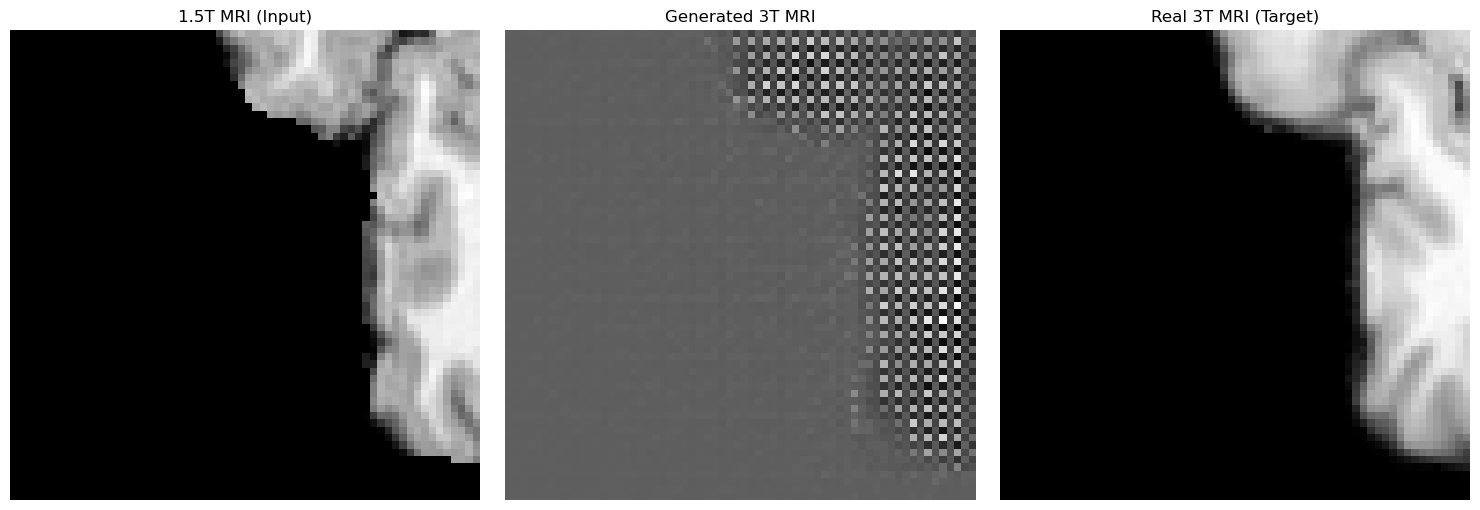

Training: |          | 0/? [00:00<?, ?it/s]

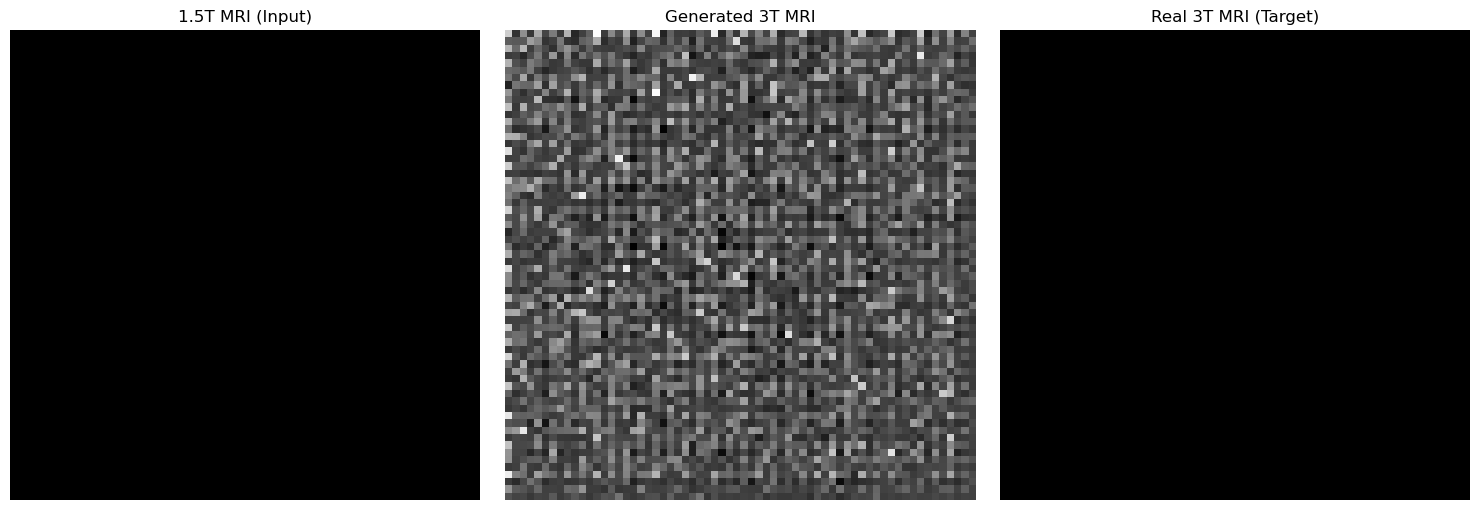

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/G_loss improved. New best score: 13.300


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/G_loss improved by 4.512 >= min_delta = 0.0. New best score: 8.787


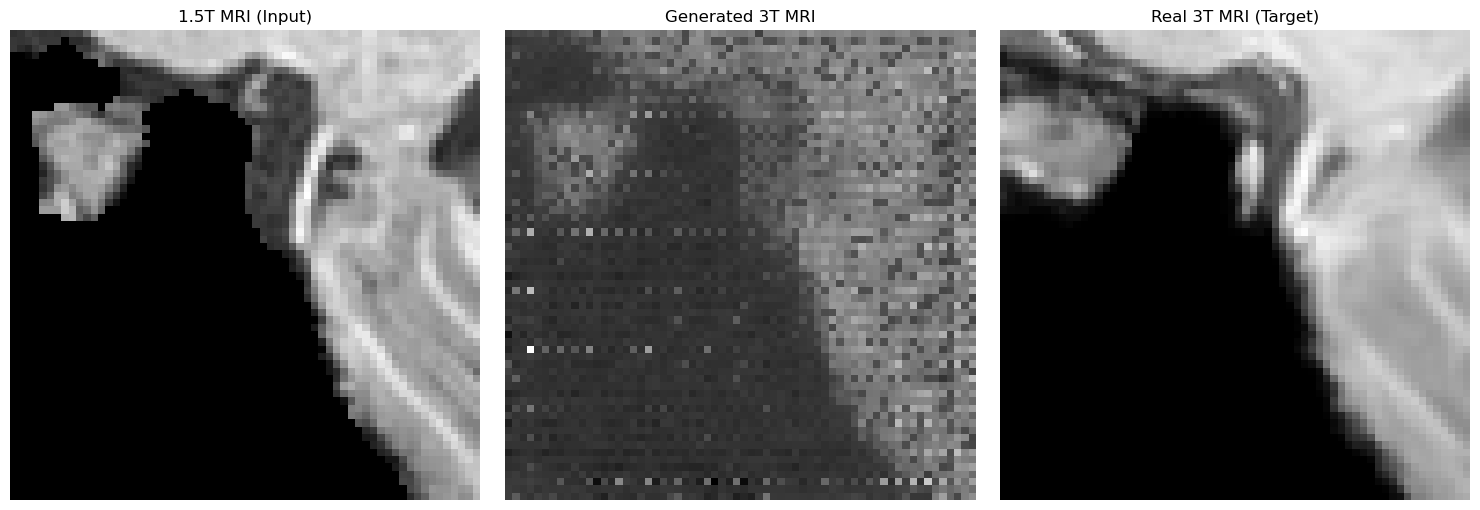

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/G_loss improved by 2.705 >= min_delta = 0.0. New best score: 6.082


Validation: |          | 0/? [00:00<?, ?it/s]

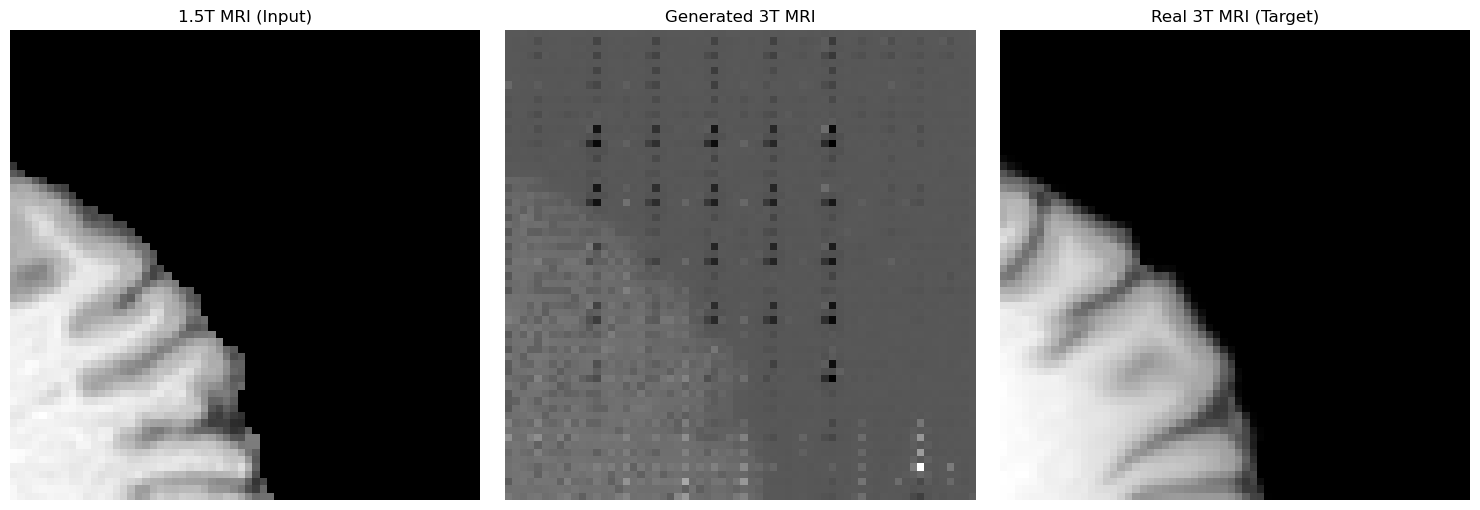

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/G_loss improved by 1.388 >= min_delta = 0.0. New best score: 4.694


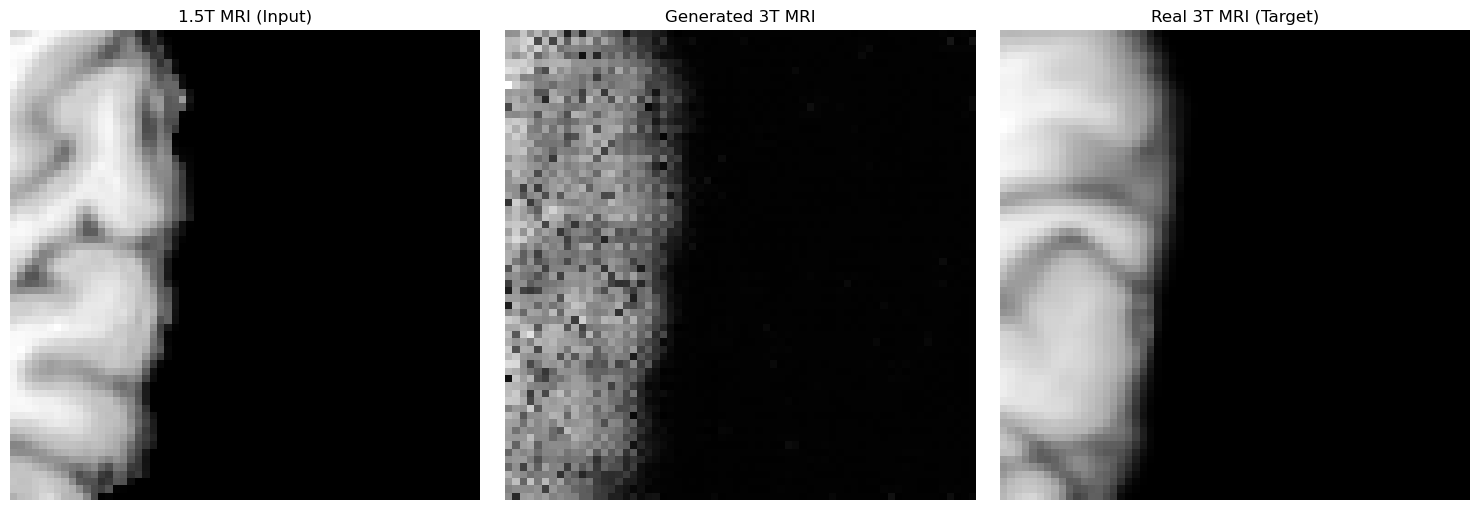


Detected KeyboardInterrupt, attempting graceful shutdown ...


❌ Training failed: name 'exit' is not defined
❌ Test training failed


In [21]:
# ================================================================
# CELL 11: Run Training (Single Fold for Testing)
# ================================================================

# Check if we have data loaded
if 'cv_splits' not in locals():
    print("❌ Please run the data loading cells first!")
else:
    # Create output directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_name = f"MRI_1.5T_to_3T_{timestamp}"
    base_output_dir = Path(config.output_dir) / experiment_name
    base_output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save configuration
    with open(base_output_dir / 'config.txt', 'w') as f:
        for key, value in vars(config).items():
            f.write(f"{key}: {value}\n")
    
    print(f"📁 Output directory created: {base_output_dir}")
    
    # Test with first fold only (change to None to run all folds)
    test_fold = 0  # Set to None to run all folds
    
    if test_fold is not None:
        print(f"\n🧪 Running test training on fold {test_fold} only")
        print("   (Set test_fold = None to run all folds)")
        
        fold_idx = test_fold
        train_subjects, val_subjects = cv_splits[fold_idx]
        
        # Create fold output directory
        fold_output_dir = base_output_dir / f"fold_{fold_idx}"
        fold_output_dir.mkdir(exist_ok=True)
        
        # Run training
        best_checkpoint = train_fold(
            fold_idx, train_subjects, val_subjects, 
            config, str(fold_output_dir)
        )
        
        if best_checkpoint:
            print(f"✅ Test training completed!")
            print(f"Best checkpoint: {best_checkpoint}")
        else:
            print("❌ Test training failed")

To monitor the performance:
1) Inside the terminal change the directory to where the results saved
2) run: tensorboard --logdir .
3) Open the link

In [ ]:
# ================================================================
# CELL 12: Run All Folds (Optional)
# ================================================================

# Uncomment and run this cell to train all folds
"""
# Run all folds
if 'cv_splits' in locals():
    print("🚀 Starting training for all folds...")
    
    # Determine which folds to run
    folds_to_run = range(config.n_folds) if config.fold_to_run is None else [config.fold_to_run]
    
    best_checkpoints = {}
    
    for fold_idx in folds_to_run:
        if fold_idx >= len(cv_splits):
            print(f"Warning: Fold {fold_idx} does not exist, skipping...")
            continue
            
        train_subjects, val_subjects = cv_splits[fold_idx]
        
        # Create fold output directory
        fold_output_dir = base_output_dir / f"fold_{fold_idx}"
        fold_output_dir.mkdir(exist_ok=True)
        
        try:
            best_checkpoint = train_fold(
                fold_idx, train_subjects, val_subjects, 
                config, str(fold_output_dir)
            )
            
            if best_checkpoint:
                best_checkpoints[fold_idx] = best_checkpoint
                print(f"✅ Fold {fold_idx} completed successfully!")
            else:
                print(f"❌ Fold {fold_idx} failed")
                
        except Exception as e:
            print(f"❌ Error training fold {fold_idx}: {str(e)}")
            continue
    
    # Summary
    print(f"\n{'='*60}")
    print("🎉 All folds training completed!")
    print(f"Results saved to: {base_output_dir}")
    print("\nBest checkpoints:")
    for fold_idx, checkpoint_path in best_checkpoints.items():
        print(f"  Fold {fold_idx}: {checkpoint_path}")
    print(f"{'='*60}")
else:
    print("❌ No CV splits available. Run data loading cells first.")
"""

In [ ]:
# ================================================================
# CELL 13: Inference Functions
# ================================================================

def load_trained_model(checkpoint_path):
    """Load trained model from checkpoint"""
    try:
        model = MRIPix2Pix.load_from_checkpoint(checkpoint_path)
        model.eval()
        print(f"✅ Model loaded from: {checkpoint_path}")
        return model
    except Exception as e:
        print(f"❌ Failed to load model: {str(e)}")
        return None


def inference_full_volume(model, input_path, output_path, patch_size=(64,64,64), overlap=16, batch_size=1):
    """Perform inference on full MRI volume"""
    
    print(f"🔮 Running inference on: {input_path}")
    
    # Load input image
    subject = tio.Subject(
        mri_15t=tio.ScalarImage(input_path)
    )
    
    # Apply same preprocessing as training
    transform = Compose([RescaleIntensity((0, 1))])
    subject = transform(subject)
    
    print(f"   Input shape: {subject['mri_15t'].shape}")
    
    # Grid sampling for full volume
    grid_sampler = GridSampler(subject, patch_size, overlap)
    patch_loader = DataLoader(grid_sampler, batch_size=batch_size, num_workers=0)
    aggregator = GridAggregator(grid_sampler)
    
    print(f"   Processing {len(patch_loader)} patches...")
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Inference
    with torch.no_grad():
        for i, patch_data in enumerate(patch_loader):
            if i % 10 == 0:
                print(f"     Patch {i+1}/{len(patch_loader)}")
                
            input_patch = patch_data['mri_15t'][DATA].to(device)
            output_patch = model(input_patch)
            aggregator.add_batch(output_patch.cpu(), patch_data[LOCATION])
    
    # Get full volume output
    output_volume = aggregator.get_output_tensor()
    
    # Save result
    output_image = tio.ScalarImage(tensor=output_volume, affine=subject['mri_15t'].affine)
    output_image.save(output_path)
    
    print(f"✅ Inference completed. Output saved to: {output_path}")
    print(f"   Output shape: {output_volume.shape}")
    
    return output_path


def visualize_results(input_path, output_path, target_path=None, slice_idx=None, figsize=(15, 5)):
    """Visualize inference results"""
    
    # Load images
    input_img = tio.ScalarImage(input_path).data.numpy().squeeze()
    output_img = tio.ScalarImage(output_path).data.numpy().squeeze()
    
    if slice_idx is None:
        slice_idx = input_img.shape[0] // 2
    
    # Create figure
    n_cols = 3 if target_path else 2
    fig, axes = plt.subplots(1, n_cols, figsize=figsize)
    
    # Input
    axes[0].imshow(input_img[slice_idx], cmap='gray')
    axes[0].set_title('1.5T Input')
    axes[0].axis('off')
    
    # Output
    axes[1].imshow(output_img[slice_idx], cmap='gray')
    axes[1].set_title('Generated 3T')
    axes[1].axis('off')
    
    # Target (if available)
    if target_path:
        target_img = tio.ScalarImage(target_path).data.numpy().squeeze()
        axes[2].imshow(target_img[slice_idx], cmap='gray')
        axes[2].set_title('Real 3T Target')
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✅ Inference functions defined")

In [ ]:
# ================================================================
# CELL 14: Example Inference (Run after training)
# ================================================================

# Example inference - uncomment and modify paths after training
"""
# Paths to your trained model and test data
checkpoint_path = "path/to/your/best_checkpoint.ckpt"
input_15t_path = "path/to/test/1.5T/subject.nii.gz"
output_3t_path = "path/to/output/generated_3T.nii.gz"
target_3t_path = "path/to/test/3T/subject.nii.gz"  # Optional for comparison

# Load trained model
model = load_trained_model(checkpoint_path)

if model is not None:
    # Run inference
    inference_full_volume(
        model=model,
        input_path=input_15t_path,
        output_path=output_3t_path,
        patch_size=config.patch_size,
        overlap=16,
        batch_size=4
    )
    
    # Visualize results
    visualize_results(
        input_path=input_15t_path,
        output_path=output_3t_path,
        target_path=target_3t_path,  # Optional
        slice_idx=None  # Will use middle slice
    )
"""

In [ ]:
# ================================================================
# CELL 15: Evaluation Metrics
# ================================================================

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_metrics(pred_path, target_path):
    """Calculate evaluation metrics between prediction and target"""
    
    # Load images
    pred_img = tio.ScalarImage(pred_path).data.numpy().squeeze()
    target_img = tio.ScalarImage(target_path).data.numpy().squeeze()
    
    print(f"Calculating metrics...")
    print(f"  Prediction shape: {pred_img.shape}")
    print(f"  Target shape: {target_img.shape}")
    
    # Ensure same shape
    if pred_img.shape != target_img.shape:
        print("❌ Shape mismatch between prediction and target!")
        return None
    
    # Calculate metrics slice by slice
    ssim_scores = []
    psnr_scores = []
    
    for i in range(pred_img.shape[0]):
        # SSIM
        ssim_score = ssim(target_img[i], pred_img[i], data_range=1.0)
        ssim_scores.append(ssim_score)
        
        # PSNR
        psnr_score = psnr(target_img[i], pred_img[i], data_range=1.0)
        psnr_scores.append(psnr_score)
    
    # Overall metrics
    metrics = {
        'ssim_mean': np.mean(ssim_scores),
        'ssim_std': np.std(ssim_scores),
        'psnr_mean': np.mean(psnr_scores),
        'psnr_std': np.std(psnr_scores),
        'mse': np.mean((pred_img - target_img) ** 2),
        'mae': np.mean(np.abs(pred_img - target_img)),
        'ncc': np.corrcoef(pred_img.flatten(), target_img.flatten())[0, 1]
    }
    
    # Print results
    print("\n📊 Evaluation Metrics:")
    print(f"  SSIM: {metrics['ssim_mean']:.4f} ± {metrics['ssim_std']:.4f}")
    print(f"  PSNR: {metrics['psnr_mean']:.2f} ± {metrics['psnr_std']:.2f} dB")
    print(f"  MSE:  {metrics['mse']:.6f}")
    print(f"  MAE:  {metrics['mae']:.6f}")
    print(f"  NCC:  {metrics['ncc']:.4f}")
    
    return metrics


def evaluate_fold_results(fold_output_dir, val_subjects, checkpoint_path):
    """Evaluate results for a specific fold"""
    
    print(f"\n🔍 Evaluating fold results...")
    print(f"Checkpoint: {checkpoint_path}")
    print(f"Validation subjects: {len(val_subjects)}")
    
    # Load model
    model = load_trained_model(checkpoint_path)
    if model is None:
        return None
    
    # Create evaluation directory
    eval_dir = Path(fold_output_dir) / "evaluation"
    eval_dir.mkdir(exist_ok=True)
    
    all_metrics = []
    
    # Process each validation subject
    for i, subject in enumerate(val_subjects):
        subject_id = subject['subject_id']
        print(f"\n  Processing {subject_id} ({i+1}/{len(val_subjects)})")
        
        # Paths
        input_path = subject['mri_15t'].path
        target_path = subject['mri_3t'].path
        output_path = eval_dir / f"{subject_id}_generated_3T.nii.gz"
        
        # Run inference
        try:
            inference_full_volume(
                model=model,
                input_path=input_path,
                output_path=str(output_path),
                patch_size=config.patch_size,
                overlap=16,
                batch_size=4
            )
            
            # Calculate metrics
            metrics = calculate_metrics(str(output_path), target_path)
            if metrics:
                metrics['subject_id'] = subject_id
                all_metrics.append(metrics)
                
        except Exception as e:
            print(f"    ❌ Failed for {subject_id}: {str(e)}")
            continue
    
    if all_metrics:
        # Aggregate metrics
        print(f"\n📈 Aggregate Results (n={len(all_metrics)}):")
        
        # Calculate means and stds
        ssim_values = [m['ssim_mean'] for m in all_metrics]
        psnr_values = [m['psnr_mean'] for m in all_metrics]
        mse_values = [m['mse'] for m in all_metrics]
        mae_values = [m['mae'] for m in all_metrics]
        ncc_values = [m['ncc'] for m in all_metrics]
        
        print(f"  SSIM: {np.mean(ssim_values):.4f} ± {np.std(ssim_values):.4f}")
        print(f"  PSNR: {np.mean(psnr_values):.2f} ± {np.std(psnr_values):.2f} dB")
        print(f"  MSE:  {np.mean(mse_values):.6f} ± {np.std(mse_values):.6f}")
        print(f"  MAE:  {np.mean(mae_values):.6f} ± {np.std(mae_values):.6f}")
        print(f"  NCC:  {np.mean(ncc_values):.4f} ± {np.std(ncc_values):.4f}")
        
        # Save results
        import pandas as pd
        df = pd.DataFrame(all_metrics)
        df.to_csv(eval_dir / "evaluation_results.csv", index=False)
        print(f"\n💾 Results saved to: {eval_dir / 'evaluation_results.csv'}")
        
        return all_metrics
    
    return None

print("✅ Evaluation functions defined")

In [ ]:
# ================================================================
# CELL 16: Monitoring and Visualization Tools
# ================================================================

def plot_training_curves(log_dir):
    """Plot training curves from TensorBoard logs"""
    try:
        from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
        
        event_acc = EventAccumulator(log_dir)
        event_acc.Reload()
        
        # Get scalar tags
        tags = event_acc.Tags()['scalars']
        
        # Plot losses
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Training losses
        if 'train/G_loss_epoch' in tags:
            g_loss = event_acc.Scalars('train/G_loss_epoch')
            steps = [x.step for x in g_loss]
            values = [x.value for x in g_loss]
            axes[0, 0].plot(steps, values, label='Generator')
        
        if 'train/D_loss_epoch' in tags:
            d_loss = event_acc.Scalars('train/D_loss_epoch')
            steps = [x.step for x in d_loss]
            values = [x.value for x in d_loss]
            axes[0, 0].plot(steps, values, label='Discriminator')
        
        axes[0, 0].set_title('Training Losses')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Validation losses
        if 'val/G_loss' in tags:
            val_g = event_acc.Scalars('val/G_loss')
            steps = [x.step for x in val_g]
            values = [x.value for x in val_g]
            axes[0, 1].plot(steps, values, label='Val Generator')
        
        if 'val/D_loss' in tags:
            val_d = event_acc.Scalars('val/D_loss')
            steps = [x.step for x in val_d]
            values = [x.value for x in val_d]
            axes[0, 1].plot(steps, values, label='Val Discriminator')
        
        axes[0, 1].set_title('Validation Losses')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Generator components
        if 'train/G_adv_epoch' in tags:
            g_adv = event_acc.Scalars('train/G_adv_epoch')
            steps = [x.step for x in g_adv]
            values = [x.value for x in g_adv]
            axes[1, 0].plot(steps, values, label='Adversarial')
        
        if 'train/G_recon_epoch' in tags:
            g_recon = event_acc.Scalars('train/G_recon_epoch')
            steps = [x.step for x in g_recon]
            values = [x.value for x in g_recon]
            axes[1, 0].plot(steps, values, label='Reconstruction')
        
        axes[1, 0].set_title('Generator Loss Components')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
        
        # Learning rates
        if 'lr-Adam' in tags:
            lr = event_acc.Scalars('lr-Adam')
            steps = [x.step for x in lr]
            values = [x.value for x in lr]
            axes[1, 1].plot(steps, values)
        
        axes[1, 1].set_title('Learning Rate')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"❌ Could not plot training curves: {str(e)}")
        print("Make sure tensorboard is installed: pip install tensorboard")


def show_training_progress(fold_output_dir):
    """Show training progress and sample images"""
    
    fold_path = Path(fold_output_dir)
    
    # Show latest sample images
    sample_images = sorted(glob.glob(str(fold_path / "*_samples.png")))
    if sample_images:
        latest_sample = sample_images[-1]
        print(f"Latest sample image: {latest_sample}")
        
        from IPython.display import Image, display
        display(Image(latest_sample))
    else:
        print("No sample images found")
    
    # Show TensorBoard logs location
    log_dirs = [d for d in fold_path.iterdir() if d.is_dir() and 'fold_' in d.name]
    if log_dirs:
        log_dir = log_dirs[0]
        print(f"\n📊 TensorBoard logs: {log_dir}")
        print(f"Run: tensorboard --logdir {log_dir}")
        
        # Try to plot curves
        plot_training_curves(str(log_dir))


def monitor_gpu_usage():
    """Monitor GPU usage during training"""
    if torch.cuda.is_available():
        print("🖥️  GPU Status:")
        print(f"   Device: {torch.cuda.get_device_name()}")
        print(f"   Memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"   Memory reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
        print(f"   Max memory: {torch.cuda.max_memory_allocated() / 1e9:.2f} GB")
    else:
        print("🖥️  Using CPU")

print("✅ Monitoring and visualization tools defined")

In [ ]:
# ================================================================
# CELL 17: Quick Start Guide and Tips
# ================================================================

print("""
🚀 QUICK START GUIDE FOR MRI TRANSLATION

1. SETUP YOUR DATA:
   - Organize your data in this structure:
     data_dir/
     ├── 1.5T/
     │   ├── subject_001.nii.gz
     │   └── ...
     └── 3T/
         ├── subject_001.nii.gz
         └── ...
   
2. UPDATE CONFIGURATION:
   - Change config.data_dir to your actual data path
   - Adjust config.batch_size if you have memory issues
   - Modify config.max_epochs for longer/shorter training

3. RUN TRAINING:
   - Execute cells 1-11 in order
   - Cell 11 runs a test fold
   - Uncomment cell 12 to run all folds

4. MONITOR TRAINING:
   - Check sample images generated during training
   - Use TensorBoard: tensorboard --logdir output_dir
   - Monitor GPU usage with monitor_gpu_usage()

5. INFERENCE:
   - Use inference_full_volume() for new images
   - Calculate metrics with calculate_metrics()
   - Visualize results with visualize_results()

💡 TIPS:
   - Start with batch_size=2 if you have memory issues
   - Use smaller patch_size (32,32,32) for limited GPU memory
   - Set max_epochs=10 for quick testing
   - Enable mixed precision (precision=16) to save memory
   - Use num_workers=0 if you have multiprocessing issues

⚠️  TROUBLESHOOTING:
   - "CUDA out of memory": Reduce batch_size or patch_size
   - "No subjects found": Check your data directory structure
   - "Training slow": Increase num_workers or use SSD storage
   - "Poor results": Increase lambda_recon or train longer

📊 EXPECTED PERFORMANCE:
   - Training time: ~2-4 hours per fold (depends on data size)
   - Memory usage: ~6-12GB VRAM (depends on batch_size)
   - Good results: SSIM > 0.8, PSNR > 25dB
   - Convergence: Usually within 50-100 epochs
""")

print("✅ Notebook ready! Update config.data_dir and start training!")

In [ ]:
# ================================================================
# CELL 18: Example Usage and Testing
# ================================================================

# Example: Quick test to verify everything works
def quick_test():
    """Quick test to verify the setup works"""
    print("🧪 Running quick functionality test...")
    
    # Test model creation
    try:
        model = MRIPix2Pix(
            in_channels=1,
            out_channels=1,
            learning_rate=1e-4,
            lambda_recon=100
        )
        print("✅ Model creation: OK")
        
        # Test forward pass
        dummy_input = torch.randn(1, 1, 32, 32, 32)
        with torch.no_grad():
            output = model(dummy_input)
        print(f"✅ Forward pass: OK (output shape: {output.shape})")
        
    except Exception as e:
        print(f"❌ Model test failed: {str(e)}")
        return False
    
    # Test data loading (if data available)
    if 'subjects' in locals() and len(subjects) > 0:
        try:
            # Test transforms
            transform = get_transforms(is_training=True)
            test_subject = transform(subjects[0])
            print("✅ Data transforms: OK")
            
        except Exception as e:
            print(f"❌ Data loading test failed: {str(e)}")
            return False
    else:
        print("⚠️  No data loaded - skipping data tests")
    
    print("✅ All tests passed!")
    return True

# Uncomment to run quick test
# quick_test()

print("🎉 MRI Translation Notebook Ready!")
print("Remember to:")
print("1. Update config.data_dir with your actual data path")
print("2. Adjust hyperparameters in the Config class")
print("3. Run cells in order from 1-11")
print("4. Monitor training progress with sample images and TensorBoard")